In [9]:
from tensorflow.keras.models import model_from_json
from convert_data import Idx

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import imageio

from sklearn.preprocessing import StandardScaler

In [10]:
model_path = "./model/model.json"
weights_path = "./model/model.h5"

# Load the model from file
model_file = open(model_path, 'r')
model = model_file.read()
model = model_from_json(model)
model_file.close()

# Load the weights from file and add them to the model
model.load_weights(weights_path)
print("Model and weights loaded")

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model and weights loaded


In [11]:
model_path = "./model/model_conv.json"
weights_path = "./model/model_conv.h5"

# Load the model from file
model_conv_file = open(model_path, 'r')
model_conv = model_conv_file.read()
model_conv = model_from_json(model_conv)
model_conv_file.close()

# Load the weights from file and add them to the model
model_conv.load_weights(weights_path)
print("ConvNet model and weights loaded")

# Compile the model
model_conv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ConvNet model and weights loaded


In [100]:
def convert_image(img, blur=3):
    # Convert to grayscale
    conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #kernel = np.ones((2, 2), np.uint8)
    #conv_img = cv2.dilate(conv_img, kernel, iterations = 1)
    
    # Adaptive thresholding to binarize the image
    conv_img = cv2.adaptiveThreshold(conv_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 4)

    # Blur the image to reduce noise
    conv_img = cv2.medianBlur(conv_img, blur)
    
    return conv_img

In [101]:
def extract_char(conv_img):
    # Find contours
    ctrs, _ = cv2.findContours(conv_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours
    return sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

In [102]:
def save_result(sorted_ctrs, img, model, class_names, lower=800, upper=20000, path='./results'):
    
    conv_size = [80, 80]
    
    # Create the target folder for saving the extracted images
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Convert original image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # Number of potential characters found in the image
    n_char = np.shape(sorted_ctrs)[0]
    
    # Go through each potential character
    for i in range(n_char):
        
        # Get coordinates of the potential character
        x, y, w, h = cv2.boundingRect(sorted_ctrs[i])
        
        # Test if the number of pixels in the bounding box is reasonable
        if (w * h) > lower and (w * h) < upper:
            
            # Extract the character and save it as a .jpeg
            roi = gray[y:y+h, x:x+w]
            roi = cv2.resize(roi, (conv_size[0], conv_size[1]))
            roi = roi.reshape(1, conv_size[0], conv_size[1])
            roi = 255 - roi
            roi = roi / 255

            if len(model.input.shape.dims) == 4:
                roi = roi.reshape(1, conv_size[0], conv_size[1], 1)
            
            prediction = model.predict(roi)

            #all_ratios.append(ratio)

            if prediction.max() > 0.08:
                char = class_names[prediction.argmax()][0]

                img = cv2.putText(
                    img, #numpy array on which text is written
                    char, #text
                    (x, y), #position at which writing has to start
                    cv2.FONT_HERSHEY_SIMPLEX, #font family
                    1, #font size
                    (209, 80, 0, 255), #font color
                    5) #font stroke
            
    
    # Return image with all bounding boxes
    cv2.imwrite(path + '/output_conv.png', img)

In [103]:
# List of all images to create the first training data 
image_files = ['./images/09.jpg']

# Read the letter names for each label
filename = './dataset/labels.txt'

file = open(filename, 'r') 
class_names =  [str.split(x) for x in file.readlines()]

# Go through all files and extract the characters
for file in image_files:

    # Read image
    img = cv2.imread(file)

    # Convert the image (gray/thresholded/blured)
    conv_img = convert_image(img)

    # Find and sort the contours
    sorted_ctrs = extract_char(conv_img)

    # Save the result
    #result = save_result(sorted_ctrs, img, model, class_names)
    
    result = save_result(sorted_ctrs, img, model_conv, class_names, lower=400)
    

In [63]:
cv2.__version__

'4.0.0'

In [97]:
img = cv2.imread(file)
conv_img = convert_image(img)

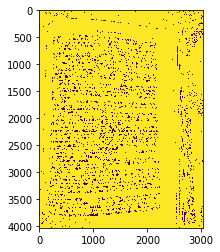

In [98]:
plt.imshow(conv_img)